# Crystal structure of the SARS-CoV-1 RBD bound by the cross-reactive single-domain antibody SARS VHH-72

## https://www.rcsb.org/structure/6WAQ

In [235]:
import nglview as nv
from Bio import PDB
from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils import seq1
from Bio.PDB import PDBIO

In [153]:
view = nv.show_file("6waq.pdb")
view

NGLWidget()

## The pdb file is made up of two christalized copies of vhh72 bound to to Sars-Cov-2 spike/Glycan protein (chain A bound to chain C and chain B bound to chain D, chain C and D not shown on figure). since our protein of interest is the vhh72 nanobody, we need to extract only this (chain A)

In [156]:
# Class for selecting a specific chain and removing water molecules
class ChainAWithoutWaterSelect(PDB.Select):
    def __init__(self, chain_id):
        self.chain_id = chain_id

    def accept_chain(self, chain):
        return chain.id == self.chain_id

    def accept_residue(self, residue):
        return residue.id[0] == " "  # Accept only standard residues, not waters or heteroatoms

# Load the PDB file
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("structure", "6waq.pdb")
linker = parser.get_structure("linker", "linker.pdb")

# Extract chain A and remove water molecules
chain_id = 'A'
io = PDB.PDBIO()
io.set_structure(structure)
io.save("vhh72.pdb", ChainAWithoutWaterSelect(chain_id))

# Function to calculate properties
def calculate_properties(chain):
    mass = 0.0
    charge = 0
    atom_count = 0
    sequence = ""

    # Iterate through residues and atoms
    for residue in chain:
        if PDB.is_aa(residue, standard=True):
            seq_res = seq1(residue.resname)
            sequence += seq_res
            mass += molecular_weight(seq_res, seq_type="protein")
            for atom in residue:
                atom_count += 1
                # Approximate charge based on residue type
                if seq_res in "KRH":
                    charge += 1  # Basic residues
                elif seq_res in "DE":
                    charge -= 1  # Acidic residues

    return mass, charge, atom_count, sequence

# Load the cleaned structure
vhh_structure = parser.get_structure("vhh_structure", "vhh72.pdb")

# Get chain A from the cleaned structure
chain_A = vhh_structure[0][chain_id]

# Calculate properties
mass, charge, atom_count, sequence = calculate_properties(chain_A)

# Output the results
print(f"Chain ID: {chain_id}")
print(f"Number of atoms: {atom_count}")
print(f"Molecular mass: {mass:.2f} Da")
print(f"Net charge: {charge}")
print(f"Amino acid sequence: {sequence}")
print(f"Sequence : {len(sequence)}")

Chain ID: A
Number of atoms: 970
Molecular mass: 16042.88 Da
Net charge: 1
Amino acid sequence: QVQLQESGGGLVQAGGSLRLSCAASGRTFSEYAMGWFRQAPGKEREFVATISWSGGSTYYTDSVKGRFTISRDNAKNTVYLQMNSLKPDDTAVYYCAAAGLGTVVSEWDYDYDYWGQGTQVTVSSGS
Sequence : 127


In [157]:
view = nv.show_file("vhh72.pdb")
view

NGLWidget()

## Now that we have our Vhh72 extracted without water molecules becauses NAMD will raise errors when generating structural file from files with water molecules.

## Let's introduce our VHH linker below. the VHH linker was designed in Spartan 24 and same result was optain from ChemDraw3D

In [158]:
nv.show_file("linker.pdb")

NGLWidget()

## There is no gold atom connected to the linker because the charm force field algorithm crashes when generating parameter files with when running a designed ligand with metal atom included. we'll manually attached the the gold atom

In [159]:
vhh = parser.get_structure("vhh", "vhh72.pdb")

last_residue = None
for model in vhh:
  for chain in model:
    for residue in chain:
      last_residue = residue  # Update last_residue for each residue

# Access information of the last residue (if found)
if last_residue:
    resname = {}
    for atom in last_residue.get_atoms():
        resname[atom.get_name()] = atom.coord
else:
    print("No residues found in the structure.")


## The connection between the vhh and linker will be made on the carbonyl atom of the serine residue. So, lets get the coordinate of the carbonyl atom only.

In [160]:
ref_atom1 = {}
for atom_name, coordinates in resname.items():
  ref_atom1[atom_name] = coordinates.tolist()
ref_atom1

{'N': [42.88399887084961, 62.0260009765625, 5.833000183105469],
 'CA': [43.6609992980957, 61.09299850463867, 6.5320000648498535],
 'C': [44.49700164794922, 61.584999084472656, 7.7129998207092285],
 'O': [45.71500015258789, 61.63100051879883, 7.5960001945495605],
 'CB': [44.59199905395508, 60.349998474121094, 5.539000034332275],
 'OG': [45.847999572753906, 60.992000579833984, 5.370999813079834]}

## Get the coordinates of the linker to calculate the translocation vector

### In order to avoid errors when iterating over each atom of the linker pdb file, you need to upload the pdb file to charmm-gui ligand modeller to generate charmm force field files and a more appropriate pdb file. https://charmm-gui.org/?doc=input/ligandrm

In [161]:
#download and untar the charmm file
!tar -xf charmm-gui.tgz

In [163]:
#!mv charmm-gui-1991583921/ charmm-gui-file

In [164]:
ligandrm = parser.get_structure("ligandrm", "charmm-gui-file/ligandrm.pdb")
# Iterate through models, chains, residues, and atoms
ref_linker_atom = {}
for model in ligandrm:
    for chain in model:
        for residue in chain:
            for atom in residue:
                # Get the current coordinates
                current_coords = atom.get_coord()
                ref_linker_atom[atom.name] = current_coords.tolist()
                print(atom.name, current_coords)

S [1.766 4.617 2.57 ]
C1 [1.769 2.785 2.43 ]
H1 [1.785 2.359 3.458]
H2 [2.7   2.442 1.926]
C2 [0.545 2.19  1.665]
H3 [-0.378  2.503  2.199]
N1 [0.511 2.81  0.274]
H4 [ 1.407  3.035 -0.152]
H5 [-0.159  2.48  -0.413]
C3 [0.607 0.648 1.764]
O [0.613 0.056 2.843]
H6 [ 0.612  0.447 -0.254]
N2 [ 0.669 -0.039  0.611]
C4 [ 0.854 -1.457  0.535]
H7 [ 0.146 -1.981  1.218]
H8 [ 1.886 -1.703  0.874]
C5 [ 0.656 -1.936 -0.837]
H9 [ 0.375 -2.624 -3.004]
C6 [ 0.509 -2.291 -1.993]
H10 [2.92  4.72  3.211]


In [165]:
#Get th reference coordinate of the linker atom
ref_linker_atom["N1"]

[0.5109999775886536, 2.809999942779541, 0.27399998903274536]

## Find the translocation vector

In [166]:
coord_ref_atom_vhh = ref_atom1["C"]
coord_ref_atom_linker = ref_linker_atom["N1"] 

# Calculate the translation vector (difference in coordinates)
translation_vector = [(a1 - a2) for a1, a2 in zip(coord_ref_atom_vhh, coord_ref_atom_linker)]
translation_vector

[43.986001670360565, 58.774999141693115, 7.438999831676483]

## Now apply the translocation vector by moving every atom coordinates by a distance of the translocation vector

In [167]:
# Iterate through each atom of the linker and add the TV
ref_linker_atom = {}
for model in ligandrm:
    for chain in model:
        for residue in chain:
            for atom in residue:
                current_coords = atom.get_coord()
                new_coords = [coord + translation for coord, translation in zip(current_coords, translation_vector)]
                atom.set_coord(new_coords)

#### bonds are automatically created at close distances, so we have to modify the transvector code up there to maintain and an average distance between the N1 and Carbonyl while keeping other atoms at safer distance preventing unwanted bonds

In [168]:
for model in ligandrm:
    for chain in model:
        for residue in chain:
            for atom in residue:
                current_coords = atom.get_coord()
                x, y, z = atom.get_coord()
                atom.set_coord([x - 1, y, z + 1])

In [171]:
#safe the new coordinates
io = PDBIO()
io.set_structure(ligandrm)
io.save("translated_linker.pdb")

#### Create a new pdb file with the combine structure of both nanobody and the new linker moved to the binding site of the nanobody

In [172]:
# Open both input files and the output file
with open("vhh72.pdb", "r") as vhh_file, \
     open("translated_linker.pdb", "r") as translocated_file, \
     open("vhh_linker.pdb", "w") as output_file:

    # write the vhh information to a new file excluding the last line containing the end statement.
    lines_to_copy = []
    for line in vhh_file:
        lines_to_copy.append(line)
    lines_to_copy = lines_to_copy[:-1]
    output_file.writelines(lines_to_copy)
         
    # Copy lines from translocated_linker.pdb to the output file
    for line in translocated_file:
        if line.startswith(('ATOM')):
            current_atom_name = line[12:16].strip()
            current_res_name = line[17:20].strip()
            # Skip the line if it matches the atom name and residue name
            if current_atom_name == 'H4' and current_res_name == 'LIG':
                continue
            if current_atom_name == 'H10' and current_res_name == 'LIG':
                continue
        # Write all other lines to the output file
        output_file.write(line)

print("Combined structure written to output_file")

Combined structure written to output_file


#### In the above process when writing the linker coordinates, we exluced one of the nitrogen's hydrogen. In order to form carbamoylation, Nitrogen looses one hydrogen to bond with the carbonyl atom. We all excluded the sulfur hydrogen since we will be introducing the gold atom below

### Add description to the new file

In [173]:
output_combined_file = "vhh_linker.pdb"
description = "HEADER      CRYSTAL STRUCTURE OF VHH72 CONNECTED TO LINKER\n"
description += "TITLE        SINGLE-DOMAIN ANTIBODY VHH-72\n"
description += "TITLE        2-AMINO-3-MERCAPTO-N-(PROP-2-YNYL)PROPIONAMIDE\n"
description += "REMARK      LINKER FROM PUBCHEM, DISIGNED IN SPARTAN TRANSFORMED IN CHARMM-GUI\n"
description += "REMARK      DATE:     7/ 2/24      6:24:39      CREATED BY USER: VAir\n"
gold_atom = "HETATM   20  AU  LIG L   1      44.752  64.392  11.009  1.00  0.00      LIG AU\n"
connect_au = "CONECT    1   20\n"

# Read the existing contents of vhh_linker.pdb
with open(output_combined_file, "r") as f:
    lines = f.readlines()

# Insert the description at the beginning of the file
lines.insert(0, description)
lines.insert(-2, gold_atom)
lines.insert(-1, connect_au)

# Write the updated contents back to vhh_linker.pdb
with open(output_combined_file, "w") as f:
    f.writelines(lines)

print(f"Description added to {output_combined_file}")

Description added to vhh_linker.pdb


In [176]:
# Load the structure file (assuming vhh_linker.pdb is your structure file)
view = nv.show_structure_file("vhh_linker.pdb")

# Change the representation to CPK (spacefill)
view.clear_representations()
view.add_representation("ball+stick", selection=":A")
view.add_representation("spacefill", selection=":L")
view

NGLWidget()

#### Spartan designs ligand with gold atom but charmm-gui crashes when transformming a ligand with gold atom, so we would add this gold atom manually, and later in the NAMD force field simulaitons, we will add the gold atom parameters coordinates manually in the charmm force field files

#### Bellow we'll upload the protein linker structure to fpocket to find the binding pocket. this will help to observe the orientation of the structure and weather the linker will in anyway obstruct the activity of the nanobody.

In [175]:
view = view = nv.show_structure_file("vhh_linker_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection=":A")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="1:C", color = "red")
view.add_representation("surface", selection="2:C")
view.add_representation("surface", selection="3:C", color = "green")
view.add_representation("surface", selection="4:C", color = "pink")
view.add_representation("surface", selection="5:C", color = "purple")
view

NGLWidget()

#### Fpocket predicted 5 pockets, with pocket 1 (red) being the most prominent with the largets surface volume for van der waals interactions.

In [177]:
view = nv.show_structure_file("vhh_linker_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection=":A")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="1:C", color = "red")
view

NGLWidget()

### Now let's proceed to namd to start the molecular dynamics simulations. we will start by solvating the system and predicting any missing atoms should in cases there is one to avoid simulation errors donwlstream. first let's use charmm-gui to generate the force field parameters

#### Defining the cell base vectors for the periodic boundary conditions need to be done appropriately to avoid errors during simulation. below we used vmd to find the minimum and maximum coordinates of atoms in our system which we use to calculate the PBC. 
>Main< (VMD) 2 % measure minmax $sel
{29.979999542236328 43.78799819946289 -45.222999572753906} {57.47100067138672 74.11100006103516 7.7129998207092285}

In [178]:
import numpy as np

# Minimum and maximum coordinates
min_coords = np.array([29.98, 43.79, -45.22])
max_coords = np.array([57.47, 74.11, 7.71])

# Calculate the box dimensions
box_dimensions = max_coords - min_coords
print(f"Box dimensions: {box_dimensions}")

# Add buffer to each dimension
buffer = 10.0
box_dimensions_with_buffer = box_dimensions + 2 * buffer
print(f"Box dimensions with buffer: {box_dimensions_with_buffer}")

# Define cellBasisVectors
cellBasisVector1 = [box_dimensions_with_buffer[0], 0.0, 0.0]
cellBasisVector2 = [0.0, box_dimensions_with_buffer[1], 0.0]
cellBasisVector3 = [0.0, 0.0, box_dimensions_with_buffer[2]]

print(f"cellBasisVector1: {cellBasisVector1}")
print(f"cellBasisVector2: {cellBasisVector2}")
print(f"cellBasisVector3: {cellBasisVector3}")


Box dimensions: [27.49 30.32 52.93]
Box dimensions with buffer: [47.49 50.32 72.93]
cellBasisVector1: [np.float64(47.489999999999995), 0.0, 0.0]
cellBasisVector2: [0.0, np.float64(50.32), 0.0]
cellBasisVector3: [0.0, 0.0, np.float64(72.93)]


#### find the origin of the pbc

In [179]:
# Given min and max coordinates
xmin, ymin, zmin = 29.98, 43.79, -45.22
xmax, ymax, zmax = 57.47, 74.11, 7.71

# Calculate the origin (center of the box)
xorigin = (xmin + xmax) / 2.0
yorigin = (ymin + ymax) / 2.0
zorigin = (zmin + zmax) / 2.0

print(f"Origin (center of the box): {xorigin}, {yorigin}, {zorigin}")
#We will use the defined parameters to insert in the cellbasicvectors

Origin (center of the box): 43.725, 58.95, -18.755


#### before lunching the simulation, we introduced the above value for the periodic boundary conditions, we also introduce reduced the number of equilibration steps to shrink the computional time due to limited computaitonal resoureces. created a bash file to lunch the complete process step after step from minization to production. 

#### In the first simulation, the system relaxes structures to ensure there are no clashes or steric hindrances, this is done in 10000 steps. also, the system equilibrates stabilize at the desire temperature and preasure, this is done in 500000 steps which is reduced from 90000000 according to charmm ff. lastly the execution is done in 125000 steps and data is collected for later analysis

#### As mentioned earlier, charm cannot generate forcefield file for both ligand and protein because of the introduction of the heteroatom. we generated force field file seperatly for protein and ligand, then introduced the force field parameter for gold as defined in the literature. we ran the NAMD simulation for protein only without any issues. for the docked molecule, below we manually integerated the structural and topology force field files to run the simulation. the following few cells calculates and find the correspondance on both files for integration.

In [136]:
# excerpt data from vhh72 and linker structural file
#from linker
atom_data_1 = """ 
         1 LIG      1        LIG      S        SG311   -0.270000       32.0600           0
         2 LIG      1        LIG      C1       CG321   -0.157000       12.0110           0
         3 LIG      1        LIG      H1       HGA2     0.900000E-01   1.00800           0
         4 LIG      1        LIG      H2       HGA2     0.900000E-01   1.00800           0
         5 LIG      1        LIG      C2       CG311    0.448000       12.0110           0
         6 LIG      1        LIG      H3       HGA1     0.900000E-01   1.00800           0
         7 LIG      1        LIG      N1       NG321    -1.16400       14.0070           0
         9 LIG      1        LIG      H5       HGPAM2   0.396000       1.00800           0
        10 LIG      1        LIG      C3       CG2O1    0.524000       12.0110           0
        11 LIG      1        LIG      O        OG2D1   -0.518000       15.9994           0
        12 LIG      1        LIG      H6       HGP1     0.323000       1.00800           0
        13 LIG      1        LIG      N2       NG2S1   -0.572000       14.0070           0
        14 LIG      1        LIG      C4       CG321    0.158000       12.0110           0
        15 LIG      1        LIG      H7       HGA2     0.900000E-01   1.00800           0
        16 LIG      1        LIG      H8       HGA2     0.900000E-01   1.00800           0
        17 LIG      1        LIG      C5       CG1T1   -0.540000E-01   12.0110           0
        18 LIG      1        LIG      H9       HGPAM1   0.290000       1.00800           0
        19 LIG      1        LIG      C6       CG1T2   -0.410000       12.0110           0
        20 LIG      1        LIG      AU      HGP3     0.160000       1.00800           0
"""
#bonds from linker
bond_data = """
        19 !NBOND: bonds
         2         3         2         4         1         2         5         6
         2         5         7         9         5         7         10        5
         10        11        12        13        10        13        14        15
         14        16        13        14        14        17        18        19
         17        19         1        20
"""
#correspondance from structural file. Noticed gold has been introduced. VDW parameters modified in charm_cgenff.prm
atom_data_2 = """
      1880 LIG      1        LIG      S        SG311   -0.270000       32.0600           0
      1881 LIG      1        LIG      C1       CG321   -0.157000       12.0110           0
      1882 LIG      1        LIG      H1       HGA2     0.900000E-01   1.00800           0
      1883 LIG      1        LIG      H2       HGA2     0.900000E-01   1.00800           0
      1884 LIG      1        LIG      C2       CG311    0.448000       12.0110           0
      1885 LIG      1        LIG      H3       HGA1     0.900000E-01   1.00800           0
      1886 LIG      1        LIG      N1       NG321   -0.768000       14.0070           0
      1887 LIG      1        LIG      H5       HGPAM2   0.396000       1.00800           0
      1888 LIG      1        LIG      C3       CG2O1    0.524000       12.0110           0
      1889 LIG      1        LIG      O        OG2D1   -0.518000       15.9994           0
      1890 LIG      1        LIG      H6       HGP1     0.323000       1.00800           0
      1891 LIG      1        LIG      N2       NG2S1   -0.572000       14.0070           0
      1892 LIG      1        LIG      C4       CG321    0.158000       12.0110           0
      1893 LIG      1        LIG      H7       HGA2     0.900000E-01   1.00800           0
      1894 LIG      1        LIG      H8       HGA2     0.900000E-01   1.00800           0
      1895 LIG      1        LIG      C5       CG1T1   -0.540000E-01   12.0110           0
      1896 LIG      1        LIG      H9       HGPAM1   0.290000       1.00800           0
      1897 LIG      1        LIG      C6       CG1T2   -0.410000       12.0110           0
      1898 LIG      1        LIG      AU       HGP3     0.010000       196.970           0
"""
#andle data to find correspondance
angle_data = """
      30 !NTHETA: angles
         2         1        20         1         2         3         1         2         4
         1         2         5         3         2         4         3         2         5
         4         2         5         2         5         6         2         5         7
         2         5        10         6         5         7         6         5        10
         7         5        10         5         7         9         5        10        11
         5        10        13        11        10        13        10        13        12
        10        13        14        12        13        14        13        14        15
        13        14        16        13        14        17        15        14        16
        15        14        17        16        14        17        14        17        19
        17        19        18
"""
#dihedrals data to find correspondance
dihedral_data = """
      34 !NPHI: dihedrals
         1         2         5         6         1         2         5         7
         1         2         5        10         2         5         7         9         
         2         5        10        11         2         5        10        13
         3         2         1        20         3         2         5         6  
         3         2         5         7         3         2         5        10    
         4         2         1        20         4         2         5         6      
         4         2         5         7         4         2         5        10   
         5         2         1        20         5        10        13        12      
         5        10        13        14         6         5         7         9
         6         5        10        11         6         5        10        13
         7         5        10        11         7         5        10        13
         9         7         5        10        10        13        14        15     
        10        13        14        16        10        13        14        17       
        11        10        13        12        11        10        13        14    
        12        13        14        15        12        13        14        16      
        12        13        14        17
"""

# Parse the first block of data
atoms_dict_1 = {}
for line in atom_data_1.strip().split('\n'):
  parts = line.split()
  index = int(parts[0])
  atom_name = parts[4]
  atom_type = parts[5]
  charge = float(parts[6])
  mass = float(parts[7])
  atoms_dict_1[index] = atom_name  # Use index as key, atom_name as value



# Parse the bond information
bonds = []
bond_lines = bond_data.strip().split('\n')[1:]  # Skip the first two lines
for line in bond_lines:
    parts = list(map(int, line.split()))
    bonds.extend([(parts[i], parts[i+1]) for i in range(0, len(parts), 2)])

# Parse the second block of data
atoms_dict_2 = {}
for line in atom_data_2.strip().split('\n'):
    parts = line.split()
    index = int(parts[0])
    atom_name = parts[4]
    atom_type = parts[5]
    charge = float(parts[6])
    mass = float(parts[7])
    atoms_dict_2[atom_name] = index

#parse angle information
angles = []
angle_lines = angle_data.strip().split('\n')[1:]  # Skip the first two lines
for line in angle_lines:
    parts = list(map(int, line.split()))
    angles.extend([(parts[i], parts[i+1], parts[i+2]) for i in range(0, len(parts), 3)])

#parse dihedrals information
dihedrals = []
dihedral_lines = dihedral_data.strip().split('\n')[1:]  # Skip the first two lines
for line in dihedral_lines:
    parts = list(map(int, line.split()))
    dihedrals.extend([(parts[i], parts[i+1], parts[i+2], parts[i+3]) for i in range(0, len(parts), 4)])


In [126]:
print(dihedrals)

[(1, 2, 5, 6), (1, 2, 5, 7), (1, 2, 5, 10), (2, 5, 7, 9), (2, 5, 10, 11), (2, 5, 10, 13), (3, 2, 1, 20), (3, 2, 5, 6), (3, 2, 5, 7), (3, 2, 5, 10), (4, 2, 1, 20), (4, 2, 5, 6), (4, 2, 5, 7), (4, 2, 5, 10), (5, 2, 1, 20), (5, 10, 13, 12), (5, 10, 13, 14), (6, 5, 7, 9), (6, 5, 10, 11), (6, 5, 10, 13), (7, 5, 10, 11), (7, 5, 10, 13), (9, 7, 5, 10), (10, 13, 14, 15), (10, 13, 14, 16), (10, 13, 14, 17), (11, 10, 13, 12), (11, 10, 13, 14), (12, 13, 14, 15), (12, 13, 14, 16), (12, 13, 14, 17)]


In [149]:
print(bonds)

[(2, 3), (2, 4), (1, 2), (5, 6), (2, 5), (7, 9), (5, 7), (10, 5), (10, 11), (12, 13), (10, 13), (14, 15), (14, 16), (13, 14), (14, 17), (18, 19), (17, 19), (1, 20)]


In [150]:
print(angles)

[(2, 1, 20), (1, 2, 3), (1, 2, 4), (1, 2, 5), (3, 2, 4), (3, 2, 5), (4, 2, 5), (2, 5, 6), (2, 5, 7), (2, 5, 10), (6, 5, 7), (6, 5, 10), (7, 5, 10), (5, 7, 9), (5, 10, 11), (5, 10, 13), (11, 10, 13), (10, 13, 12), (10, 13, 14), (12, 13, 14), (13, 14, 15), (13, 14, 16), (13, 14, 17), (15, 14, 16), (15, 14, 17), (16, 14, 17), (14, 17, 19), (17, 19, 18)]


In [140]:
#find bonds correspondance
bonds_list = []  # Create an empty list to store bonds
for bond in bonds:
  atom1 = atoms_dict_1[bond[0]]  # Access atom names using index
  atom2 = atoms_dict_1[bond[1]]
  bonds_list.append((atom1, atom2))  # Append a tuple to the list

print(bonds_list)

[('C1', 'H1'), ('C1', 'H2'), ('S', 'C1'), ('C2', 'H3'), ('C1', 'C2'), ('N1', 'H5'), ('C2', 'N1'), ('C3', 'C2'), ('C3', 'O'), ('H6', 'N2'), ('C3', 'N2'), ('C4', 'H7'), ('C4', 'H8'), ('N2', 'C4'), ('C4', 'C5'), ('H9', 'C6'), ('C5', 'C6'), ('S', 'AU')]


In [141]:
#find angle correspondance
angles_list = []  # Create an empty list to store bonds
for bond in angles:
  atom1 = atoms_dict_1[bond[0]]  # Access atom names using index
  atom2 = atoms_dict_1[bond[1]]
  atom3 = atoms_dict_1[bond[2]]
  angles_list.append((atom1, atom2, atom3))  # Append a tuple to the list

print(angles_list)

[('C1', 'S', 'AU'), ('S', 'C1', 'H1'), ('S', 'C1', 'H2'), ('S', 'C1', 'C2'), ('H1', 'C1', 'H2'), ('H1', 'C1', 'C2'), ('H2', 'C1', 'C2'), ('C1', 'C2', 'H3'), ('C1', 'C2', 'N1'), ('C1', 'C2', 'C3'), ('H3', 'C2', 'N1'), ('H3', 'C2', 'C3'), ('N1', 'C2', 'C3'), ('C2', 'N1', 'H5'), ('C2', 'C3', 'O'), ('C2', 'C3', 'N2'), ('O', 'C3', 'N2'), ('C3', 'N2', 'H6'), ('C3', 'N2', 'C4'), ('H6', 'N2', 'C4'), ('N2', 'C4', 'H7'), ('N2', 'C4', 'H8'), ('N2', 'C4', 'C5'), ('H7', 'C4', 'H8'), ('H7', 'C4', 'C5'), ('H8', 'C4', 'C5'), ('C4', 'C5', 'C6'), ('C5', 'C6', 'H9')]


In [142]:
#find dihedrals correspondance
dihedrals_list = []  # Create an empty list to store bonds
for bond in dihedrals:
  atom1 = atoms_dict_1[bond[0]]  # Access atom names using index
  atom2 = atoms_dict_1[bond[1]]
  atom3 = atoms_dict_1[bond[2]]
  atom4 = atoms_dict_1[bond[3]]
  dihedrals_list.append((atom1, atom2, atom3, atom4))  # Append a tuple to the list

print(dihedrals_list)

[('S', 'C1', 'C2', 'H3'), ('S', 'C1', 'C2', 'N1'), ('S', 'C1', 'C2', 'C3'), ('C1', 'C2', 'N1', 'H5'), ('C1', 'C2', 'C3', 'O'), ('C1', 'C2', 'C3', 'N2'), ('H1', 'C1', 'S', 'AU'), ('H1', 'C1', 'C2', 'H3'), ('H1', 'C1', 'C2', 'N1'), ('H1', 'C1', 'C2', 'C3'), ('H2', 'C1', 'S', 'AU'), ('H2', 'C1', 'C2', 'H3'), ('H2', 'C1', 'C2', 'N1'), ('H2', 'C1', 'C2', 'C3'), ('C2', 'C1', 'S', 'AU'), ('C2', 'C3', 'N2', 'H6'), ('C2', 'C3', 'N2', 'C4'), ('H3', 'C2', 'N1', 'H5'), ('H3', 'C2', 'C3', 'O'), ('H3', 'C2', 'C3', 'N2'), ('N1', 'C2', 'C3', 'O'), ('N1', 'C2', 'C3', 'N2'), ('H5', 'N1', 'C2', 'C3'), ('C3', 'N2', 'C4', 'H7'), ('C3', 'N2', 'C4', 'H8'), ('C3', 'N2', 'C4', 'C5'), ('O', 'C3', 'N2', 'H6'), ('O', 'C3', 'N2', 'C4'), ('H6', 'N2', 'C4', 'H7'), ('H6', 'N2', 'C4', 'H8'), ('H6', 'N2', 'C4', 'C5')]


In [143]:
#get the bond correspondance
bonds_list_translated = []
for bond in bonds_list:
  atom1_idx = atoms_dict_2[bond[0]]  # Access atom names using index
  atom2_idx = atoms_dict_2[bond[1]]
  bonds_list_translated += (atom1_idx, atom2_idx)  # Append a tuple to the list

print(bonds_list_translated)

[1881, 1882, 1881, 1883, 1880, 1881, 1884, 1885, 1881, 1884, 1886, 1887, 1884, 1886, 1888, 1884, 1888, 1889, 1890, 1891, 1888, 1891, 1892, 1893, 1892, 1894, 1891, 1892, 1892, 1895, 1896, 1897, 1895, 1897, 1880, 1898]


In [144]:
#present the bond correspondance for easy introduction in the structural file
output_string = ""

# Loop through each element in the list
for element in bonds_list_translated:
  # Convert element to string and add a space at the end
  output_string += str(element) + "      "

# Print the final string without the trailing space
print(output_string)

1881      1882      1881      1883      1880      1881      1884      1885      1881      1884      1886      1887      1884      1886      1888      1884      1888      1889      1890      1891      1888      1891      1892      1893      1892      1894      1891      1892      1892      1895      1896      1897      1895      1897      1880      1898      


In [145]:
#get the angle correspondance
angles_list_translated = []
for angle in angles_list:
  atom1_idx = atoms_dict_2[angle[0]]  # Access atom names using index
  atom2_idx = atoms_dict_2[angle[1]]
  atom3_idx = atoms_dict_2[angle[2]]
  angles_list_translated += (atom1_idx, atom2_idx, atom3_idx)  # Append a tuple to the list

print(angles_list_translated)

[1881, 1880, 1898, 1880, 1881, 1882, 1880, 1881, 1883, 1880, 1881, 1884, 1882, 1881, 1883, 1882, 1881, 1884, 1883, 1881, 1884, 1881, 1884, 1885, 1881, 1884, 1886, 1881, 1884, 1888, 1885, 1884, 1886, 1885, 1884, 1888, 1886, 1884, 1888, 1884, 1886, 1887, 1884, 1888, 1889, 1884, 1888, 1891, 1889, 1888, 1891, 1888, 1891, 1890, 1888, 1891, 1892, 1890, 1891, 1892, 1891, 1892, 1893, 1891, 1892, 1894, 1891, 1892, 1895, 1893, 1892, 1894, 1893, 1892, 1895, 1894, 1892, 1895, 1892, 1895, 1897, 1895, 1897, 1896]


In [146]:
#present the angle correspondance for easy introduction in the structural file
output_string = ""

# Loop through each element in the list
for element in angles_list_translated:
  # Convert element to string and add a space at the end
  output_string += str(element) + "      "

# Print the final string without the trailing space
print(output_string)

1881      1880      1898      1880      1881      1882      1880      1881      1883      1880      1881      1884      1882      1881      1883      1882      1881      1884      1883      1881      1884      1881      1884      1885      1881      1884      1886      1881      1884      1888      1885      1884      1886      1885      1884      1888      1886      1884      1888      1884      1886      1887      1884      1888      1889      1884      1888      1891      1889      1888      1891      1888      1891      1890      1888      1891      1892      1890      1891      1892      1891      1892      1893      1891      1892      1894      1891      1892      1895      1893      1892      1894      1893      1892      1895      1894      1892      1895      1892      1895      1897      1895      1897      1896      


In [147]:
#get the dihedral correspondance
dihedrals_list_translated = []
for angle in dihedrals_list:
  atom1_idx = atoms_dict_2[angle[0]]  # Access atom names using index
  atom2_idx = atoms_dict_2[angle[1]]
  atom3_idx = atoms_dict_2[angle[2]]
  atom4_idx = atoms_dict_2[angle[3]]
  dihedrals_list_translated += (atom1_idx, atom2_idx, atom3_idx, atom4_idx)  # Append a tuple to the list

print(dihedrals_list_translated)
len(dihedrals_list_translated)

[1880, 1881, 1884, 1885, 1880, 1881, 1884, 1886, 1880, 1881, 1884, 1888, 1881, 1884, 1886, 1887, 1881, 1884, 1888, 1889, 1881, 1884, 1888, 1891, 1882, 1881, 1880, 1898, 1882, 1881, 1884, 1885, 1882, 1881, 1884, 1886, 1882, 1881, 1884, 1888, 1883, 1881, 1880, 1898, 1883, 1881, 1884, 1885, 1883, 1881, 1884, 1886, 1883, 1881, 1884, 1888, 1884, 1881, 1880, 1898, 1884, 1888, 1891, 1890, 1884, 1888, 1891, 1892, 1885, 1884, 1886, 1887, 1885, 1884, 1888, 1889, 1885, 1884, 1888, 1891, 1886, 1884, 1888, 1889, 1886, 1884, 1888, 1891, 1887, 1886, 1884, 1888, 1888, 1891, 1892, 1893, 1888, 1891, 1892, 1894, 1888, 1891, 1892, 1895, 1889, 1888, 1891, 1890, 1889, 1888, 1891, 1892, 1890, 1891, 1892, 1893, 1890, 1891, 1892, 1894, 1890, 1891, 1892, 1895]


124

In [148]:
#present the dihedral correspondance for easy introduction into the structural file
output_string = ""

# Loop through each element in the list
for element in dihedrals_list_translated:
  # Convert element to string and add a space at the end
  output_string += str(element) + "      "

# Print the final string without the trailing space
print(output_string)

1880      1881      1884      1885      1880      1881      1884      1886      1880      1881      1884      1888      1881      1884      1886      1887      1881      1884      1888      1889      1881      1884      1888      1891      1882      1881      1880      1898      1882      1881      1884      1885      1882      1881      1884      1886      1882      1881      1884      1888      1883      1881      1880      1898      1883      1881      1884      1885      1883      1881      1884      1886      1883      1881      1884      1888      1884      1881      1880      1898      1884      1888      1891      1890      1884      1888      1891      1892      1885      1884      1886      1887      1885      1884      1888      1889      1885      1884      1888      1891      1886      1884      1888      1889      1886      1884      1888      1891      1887      1886      1884      1888      1888      1891      1892      1893      1888      1891      1892      1894      

### After simulation first find the RMSD for the protein backbone, then the rmsd per residue. RMSD per residue provide protein mobility per residue and an overview of the structural stability of the protein while rmsd for the protein backbone provides an overview of possible conformational changes along the simulation. 

### next is to find the temperature fluctuation which is the measure of the heat released by the atoms vibration during simulation. this also supports the question of thermostability, while it doesn't define the optimal stability of the molecule but a less stable fluctuation represents a more stable atom while more fluctuation defines i less stable molecule.

### next we can compare the docked protein with the undocked protein to find if there were any structural changes during the process. RMSD shows that conformational changes have been incured during the process and some residues became more mobile but what is unsure is if the conformational changes affects the bonding site. Let's verify this wit fpocket!

In [267]:
view = view = nv.show_structure_file("dcd_to_pdb_frame0_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection="1-115")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="1:C", color = "red")
view

NGLWidget()

In [266]:
view = view = nv.show_structure_file("dcd_to_pdb_frame27_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection="1-115")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="1:C", color = "red")
view

NGLWidget()

In [268]:
view = view = nv.show_structure_file("dcd_to_pdb_frame13_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection="1-115")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="5:C", color = "red")
view

NGLWidget()

In [271]:
view = view = nv.show_structure_file("dcd_to_pdb_vhh_frame27_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection="1-115")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="1:C", color = "red")
view

NGLWidget()

In [272]:
view = view = nv.show_structure_file("dcd_to_pdb_vhh_frame1_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection="1-115")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="1:C", color = "red")
view

NGLWidget()

In [274]:
view = view = nv.show_structure_file("dcd_to_pdb_vhh_frame13_pocket.pdb")

view.clear_representations()
view.add_representation("ball+stick", selection="1-115")
view.add_representation("spacefill", selection=":L")
view.add_representation("surface", selection="1:C", color = "red")
view

NGLWidget()

### The above simulations shows that the conformational changes modifies the binding site of the nanobodes at some point of the simulation.

### Below we plot the energy data obtain during the minimization process for Vhh72 and the linker.

### All data below are from NAMD simulation

Total simulation time: 270.0 ps


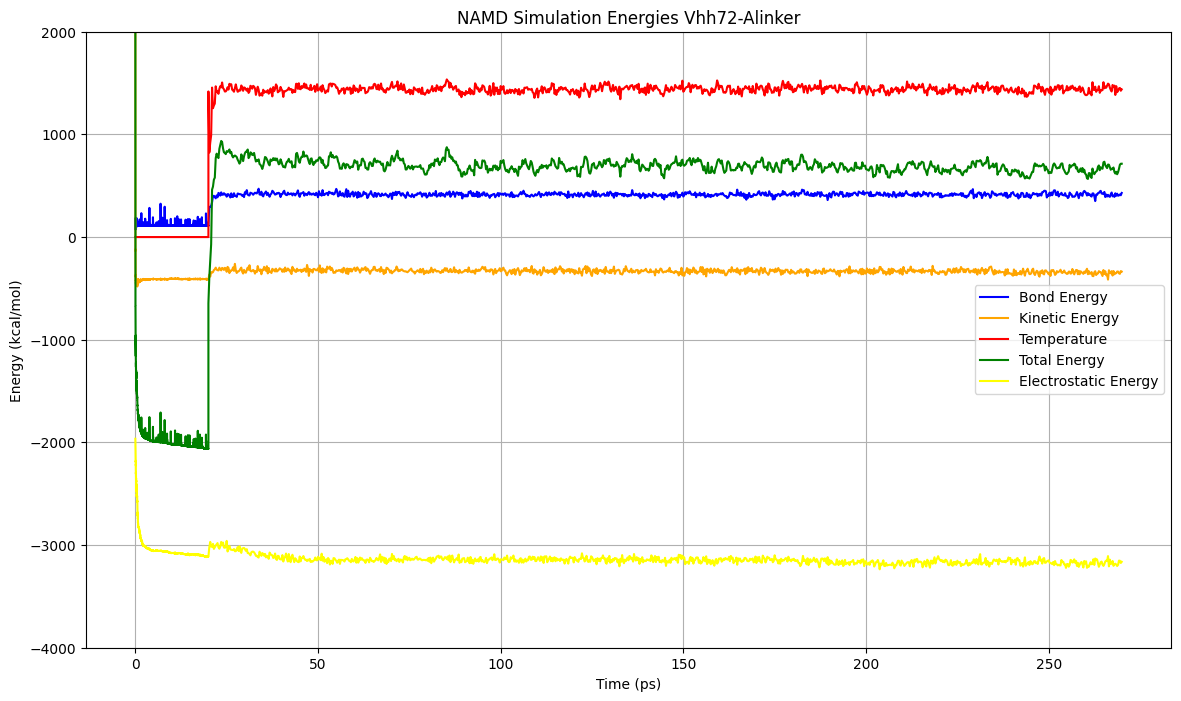

In [234]:
import re
import matplotlib.pyplot as plt

def parse_namd_log(log_file):
    # Regular expressions to match lines in the log file
    energy_re = re.compile(
        r"^ENERGY:\s+(\d+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)"
    )

    # Lists to hold the parsed data
    steps = []
    bond_energies = []
    kinetic_energies = []
    total_energies = []
    temperatures = []
    electrostatic = []

    # Open and parse the log file
    with open(log_file, 'r') as file:
        for line in file:
            match = energy_re.match(line)
            if match:
                steps.append(int(match.group(1)))
                bond_energies.append(float(match.group(2)))
                kinetic_energies.append(float(match.group(7)))
                total_energies.append(float(match.group(11)))
                temperatures.append(float(match.group(10)))
                electrostatic.append(float(match.group(6)))

    return steps, bond_energies, kinetic_energies, total_energies, temperatures, electrostatic

def plot_energies(steps, bond_energies, kinetic_energies, total_energies, temperatures,electrostatic, time_step, y_min, y_max):
    # Convert steps to time (ps)
    times = [step * time_step for step in steps]

    plt.figure(figsize=(14, 8))

    # Plot bond energies
    plt.plot(times, bond_energies, label='Bond Energy', color='blue')

    # Plot kinetic energies
    plt.plot(times, kinetic_energies, label='Kinetic Energy', color='orange')

    # Plot temperatures
    plt.plot(times, temperatures, label='Temperature', color='red')

    # Plot total energies
    plt.plot(times, total_energies, label='Total Energy', color='green')

    # Plot electrostatic energies
    plt.plot(times, electrostatic, label='Electrostatic Energy', color='yellow')

    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (kcal/mol)')
    plt.title('NAMD Simulation Energies Vhh72-Alinker')
    plt.legend()
    plt.grid(True)

    # Setting y-axis limits to focus on the part with data
    plt.ylim(y_min, y_max)

    plt.show()

# Use the functions defined above
log_file = 'step4_equilibration.out'  # Replace with your actual log file name
time_step = 2.0 * 0.001  # Time step in picoseconds (assuming 2 fs time step in NAMD)

# Calculate total simulation time based on time_step and number of steps
steps, bond_energies, kinetic_energies, total_energies, temperatures, electrostatic = parse_namd_log(log_file)
total_simulation_time = steps[-1] * time_step

print(f"Total simulation time: {total_simulation_time} ps")

# Manually specify y-axis limits to zoom in on relevant data
y_min = -4000  # Set to your desired minimum y value
y_max = 2000   # Set to your desired maximum y value

# Plot energies with manual y-axis zoom
plot_energies(steps, bond_energies, kinetic_energies, total_energies, temperatures, electrostatic, time_step, y_min, y_max)

### plot the RMSD deviation from the Vhh72 - linker minimization

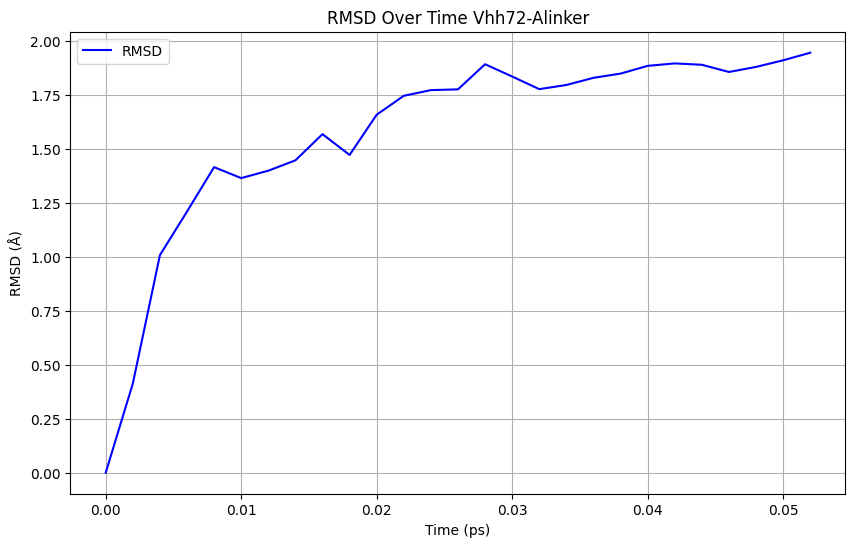

In [232]:
import matplotlib.pyplot as plt

def parse_rmsd_file(rmsd_file):
    rmsd_values = []
    with open(rmsd_file, 'r') as file:
        for line in file:
            rmsd_values.append(float(line.strip()))
    return rmsd_values

def plot_rmsd(rmsd_values, time_step):
    # Convert the number of frames to time (ps)
    times = [i * time_step for i in range(len(rmsd_values))]

    plt.figure(figsize=(10, 6))
    plt.plot(times, rmsd_values, label='RMSD', color='blue')
    plt.xlabel('Time (ps)')
    plt.ylabel('RMSD (Å)')
    plt.title('RMSD Over Time Vhh72-Alinker')
    plt.legend()
    plt.grid(True)
    plt.show()

# Use the functions defined above
rmsd_file = 'rmsd.dat'  # Replace with your actual RMSD file name
time_step = 2.0 * 0.001  # Time step in picoseconds (assuming 2 fs time step in NAMD)

# Parse the RMSD file and plot
rmsd_values = parse_rmsd_file(rmsd_file)
plot_rmsd(rmsd_values, time_step)


### plot the RMSD per residue for the Vhh72-linker minimization

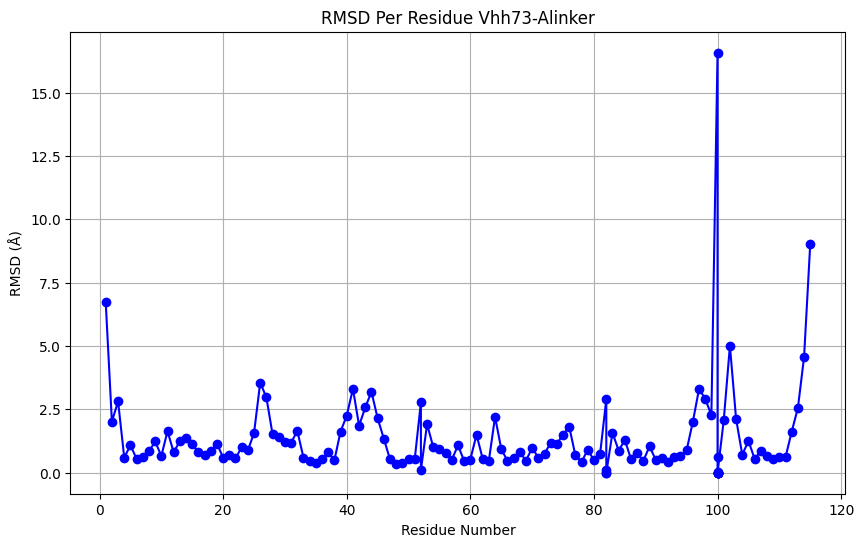

In [231]:
import matplotlib.pyplot as plt

def parse_rmsd_per_residue(rmsd_per_residue_file):
    residue_numbers = []
    rmsd_values = []
    with open(rmsd_per_residue_file, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                residue_numbers.append(int(parts[0]))
                rmsd_values.append(float(parts[1]))
    return residue_numbers, rmsd_values

def plot_rmsd_per_residue(residue_numbers, rmsd_values):
    plt.figure(figsize=(10, 6))
    plt.plot(residue_numbers, rmsd_values, marker='o', linestyle='-', color='blue')
    plt.xlabel('Residue Number')
    plt.ylabel('RMSD (Å)')
    plt.title('RMSD Per Residue Vhh72
    -Alinker')
    plt.grid(True)
    plt.show()

# Use the functions defined above
rmsd_per_residue_file = 'residue_rmsd.dat'  # Replace with your actual RMSD per residue file name

# Parse the RMSD per residue file
residue_numbers, rmsd_values = parse_rmsd_per_residue(rmsd_per_residue_file)

# Plot RMSD per residue
plot_rmsd_per_residue(residue_numbers, rmsd_values)


### Let's repeat the process for Vhh72 minimization only starting with the energies

Total simulation time: 270.0 ps


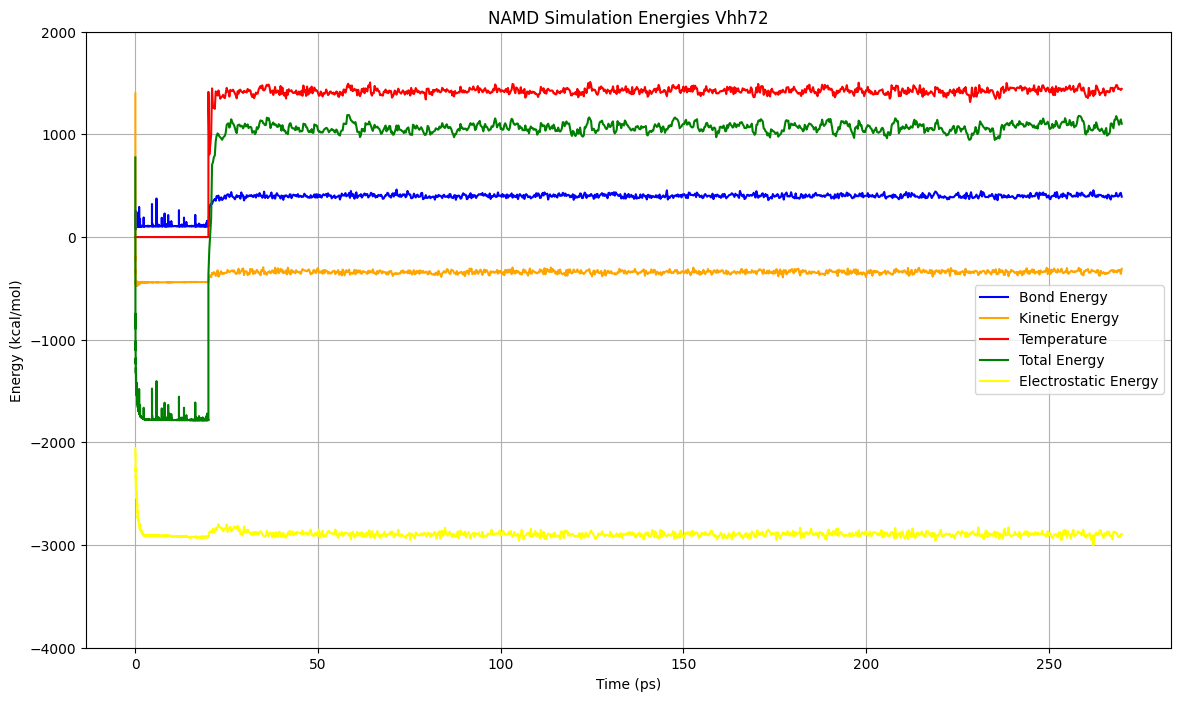

In [260]:
import re
import matplotlib.pyplot as plt

def parse_namd_log(log_file):
    # Regular expressions to match lines in the log file
    energy_re = re.compile(
        r"^ENERGY:\s+(\d+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)"
    )

    # Lists to hold the parsed data
    steps = []
    bond_energies = []
    kinetic_energies = []
    total_energies = []
    temperatures = []
    electrostatic = []

    # Open and parse the log file
    with open(log_file, 'r') as file:
        for line in file:
            match = energy_re.match(line)
            if match:
                steps.append(int(match.group(1)))
                bond_energies.append(float(match.group(2)))
                kinetic_energies.append(float(match.group(7)))
                total_energies.append(float(match.group(11)))
                temperatures.append(float(match.group(10)))
                electrostatic.append(float(match.group(6)))

    return steps, bond_energies, kinetic_energies, total_energies, temperatures, electrostatic

def plot_energies(steps, bond_energies, kinetic_energies, total_energies, temperatures,electrostatic, time_step, y_min, y_max):
    # Convert steps to time (ps)
    times = [step * time_step for step in steps]

    plt.figure(figsize=(14, 8))

    # Plot bond energies
    plt.plot(times, bond_energies, label='Bond Energy', color='blue')

    # Plot kinetic energies
    plt.plot(times, kinetic_energies, label='Kinetic Energy', color='orange')

    # Plot temperatures
    plt.plot(times, temperatures, label='Temperature', color='red')

    # Plot total energies
    plt.plot(times, total_energies, label='Total Energy', color='green')

    # Plot electrostatic energies
    plt.plot(times, electrostatic, label='Electrostatic Energy', color='yellow')

    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (kcal/mol)')
    plt.title('NAMD Simulation Energies Vhh72')
    plt.legend()
    plt.grid(True)

    # Setting y-axis limits to focus on the part with data
    plt.ylim(y_min, y_max)

    plt.show()

# Use the functions defined above
log_file = 'step4_equilibration_vhh.out'  
time_step = 2.0 * 0.001  # Time step in picoseconds (assuming 2 fs time step in NAMD)

# Calculate total simulation time based on time_step and number of steps
steps, bond_energies, kinetic_energies, total_energies, temperatures, electrostatic = parse_namd_log(log_file)
total_simulation_time = steps[-1] * time_step

print(f"Total simulation time: {total_simulation_time} ps")

# Manually specify y-axis limits to zoom in on relevant data
y_min = -4000  # Set to your desired minimum y value
y_max = 2000   # Set to your desired maximum y value

# Plot energies with manual y-axis zoom
plot_energies(steps, bond_energies, kinetic_energies, total_energies, temperatures, electrostatic, time_step, y_min, y_max)

### RMSD for vhh72

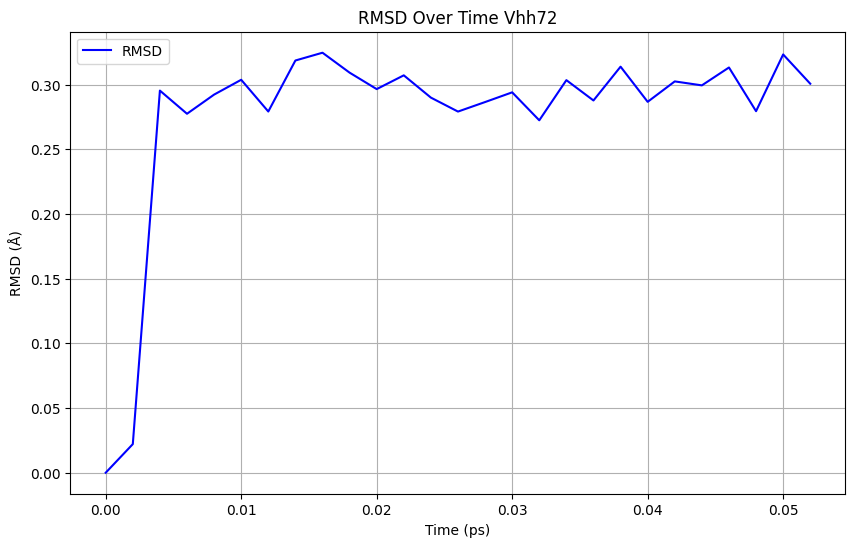

In [262]:
import matplotlib.pyplot as plt

def parse_rmsd_file(rmsd_file):
    rmsd_values = []
    with open(rmsd_file, 'r') as file:
        for line in file:
            rmsd_values.append(float(line.strip()))
    return rmsd_values

def plot_rmsd(rmsd_values, time_step):
    # Convert the number of frames to time (ps)
    times = [i * time_step for i in range(len(rmsd_values))]

    plt.figure(figsize=(10, 6))
    plt.plot(times, rmsd_values, label='RMSD', color='blue')
    plt.xlabel('Time (ps)')
    plt.ylabel('RMSD (Å)')
    plt.title('RMSD Over Time Vhh72')
    plt.legend()
    plt.grid(True)
    plt.show()

# Use the functions defined above
rmsd_file = 'rmsd_vhh.dat'  # Replace with your actual RMSD file name
time_step = 2.0 * 0.001  # Time step in picoseconds (assuming 2 fs time step in NAMD)

# Parse the RMSD file and plot
rmsd_values = parse_rmsd_file(rmsd_file)
plot_rmsd(rmsd_values, time_step)

### RMSD per residue for Vhh72

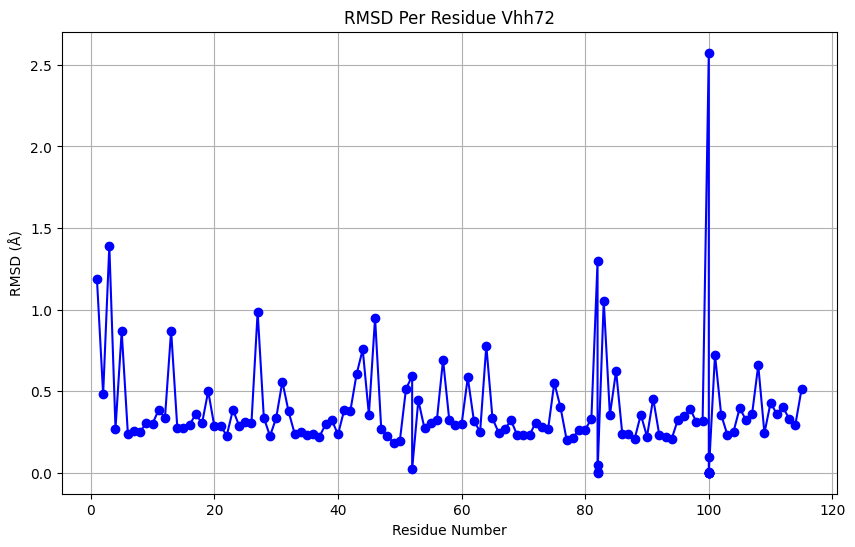

In [261]:
import matplotlib.pyplot as plt

def parse_rmsd_per_residue(rmsd_per_residue_file):
    residue_numbers = []
    rmsd_values = []
    with open(rmsd_per_residue_file, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                residue_numbers.append(int(parts[0]))
                rmsd_values.append(float(parts[1]))
    return residue_numbers, rmsd_values

def plot_rmsd_per_residue(residue_numbers, rmsd_values):
    plt.figure(figsize=(10, 6))
    plt.plot(residue_numbers, rmsd_values, marker='o', linestyle='-', color='blue')
    plt.xlabel('Residue Number')
    plt.ylabel('RMSD (Å)')
    plt.title('RMSD Per Residue Vhh72')
    plt.grid(True)
    plt.show()

# Use the functions defined above
rmsd_per_residue_file = 'residue_rmsd_vhh.dat'  # Replace with your actual RMSD per residue file name

# Parse the RMSD per residue file
residue_numbers, rmsd_values = parse_rmsd_per_residue(rmsd_per_residue_file)

# Plot RMSD per residue
plot_rmsd_per_residue(residue_numbers, rmsd_values)


### superposition of both simulations to show residue mobilities between the docked and undocked protein

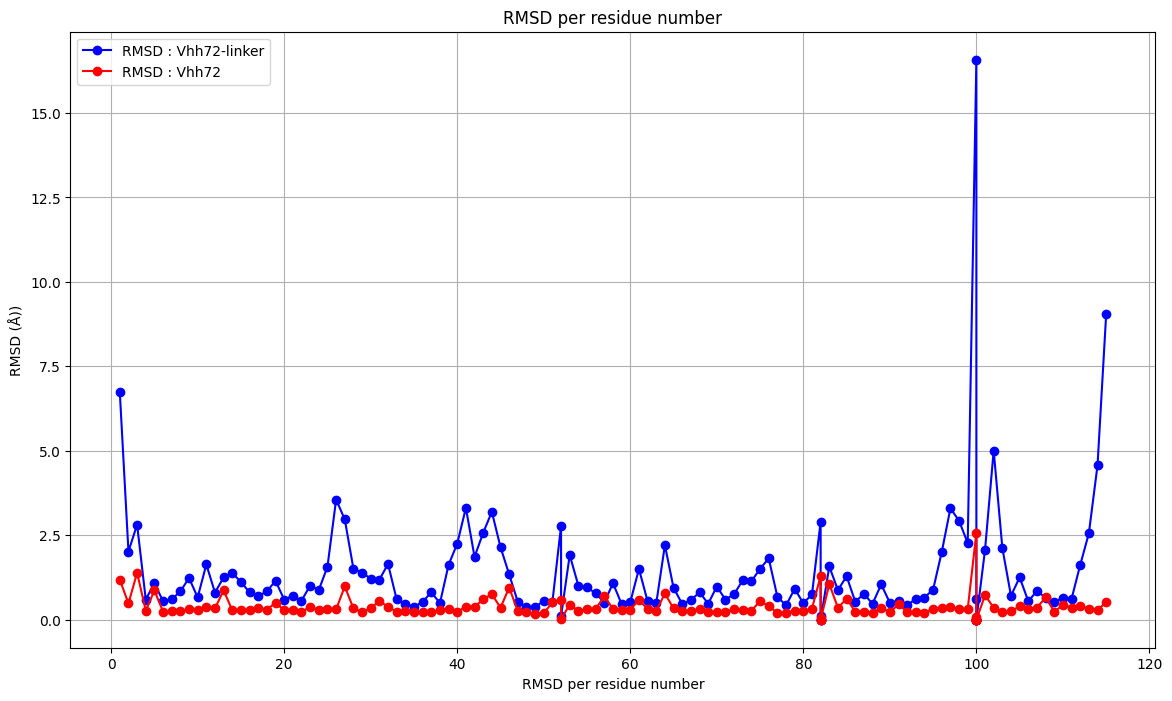

In [263]:
def plot_rmsd_per_residue(resid1, resid2):
    plt.figure(figsize=(14, 8))
    residue_numbers, rmsd_values = parse_rmsd_per_residue(resid1)
    plt.plot(residue_numbers, rmsd_values, label='RMSD : Vhh72-linker', marker='o', linestyle='-', color='blue')
    residue_numbers, rmsd_values = parse_rmsd_per_residue(resid2)
    plt.plot(residue_numbers, rmsd_values, label='RMSD : Vhh72', marker='o', linestyle='-', color='red')

    plt.xlabel('RMSD per residue number')
    plt.ylabel('RMSD (Å))')
    plt.title('RMSD per residue number')
    plt.legend()
    plt.grid(True)
# Plot energies with manual y-axis zoom
plot_rmsd_per_residue("residue_rmsd.dat", "residue_rmsd_vhh.dat")

### overlaying the RMSD to show the differences in conformational changes.

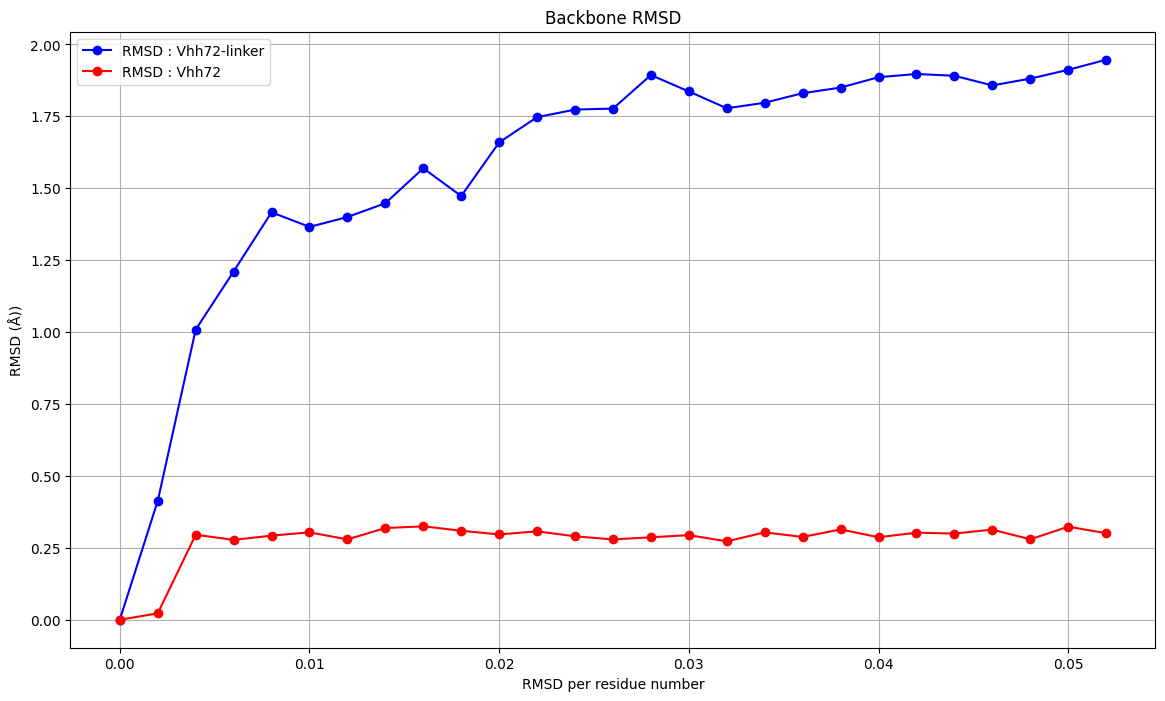

In [264]:
def plot_rmsd(resid1, resid2, time_step):
    plt.figure(figsize=(14, 8))
    rmsd_values = parse_rmsd_file(resid1)
    times = [i * time_step for i in range(len(rmsd_values))]
    plt.plot(times, rmsd_values, label='RMSD : Vhh72-linker', marker='o', linestyle='-', color='blue')
    rmsd_values = parse_rmsd_file(resid2)
    plt.plot(times, rmsd_values, label='RMSD : Vhh72', marker='o', linestyle='-', color='red')

    plt.xlabel('RMSD per residue number')
    plt.ylabel('RMSD (Å))')
    plt.title('Backbone RMSD')
    plt.legend()
    plt.grid(True)

time_step = 2.0 * 0.001  # Time step in picoseconds (assuming 2 fs time step in NAMD)

plot_rmsd("rmsd.dat", "rmsd_vhh.dat", time_step)

In [ ]:
#The main idea here is to show if all energies reaches equilibrium and the time taken to reach equilibrium. 
#Hicks C et al. simulated 9 biomarkers and showed that  amongst the biomarkers, the most stable biomarker took the least time to reach equilibrium.
#From the energy state definitions, it is important to prevent the biosensor from light radiation to avoid energy exchange with external system and maintain the system intrinsic stability.
